In [1]:
import csv
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier

In [2]:
start_date = pd.Timestamp('2011/01/24')
stop_date = pd.Timestamp('2015/12/13')

In [3]:
def reload_data():
    global df
    df = pd.read_csv('employee_retention_data.csv')
    df.sort_values(['employee_id'],inplace=True)
    df['join_date'] = pd.to_datetime(df['join_date'])
    df['quit_date'] = pd.to_datetime(df['quit_date'])

In [4]:
def feature_engineer():
    global df
    df['time_since_join'] = stop_date - df['join_date'] 
    df['time_until_quit'] = (df['quit_date'] - df['join_date']).dt.days
    df['last_employment_day'] = df['quit_date'].fillna(stop_date)
    df['duration'] = (df['last_employment_day'] - df['join_date']).dt.days
    df['quit'] = np.invert(df['quit_date'].isnull())
    df['salary/seniority'] = df['salary'] / df['seniority']
    df['salary/duration'] = df['salary'] / df['duration']
    df['salary/(duration*seniority)'] = df['salary'] / ( df['seniority'] * df['duration'])
    df['seniority_at_end'] = df['seniority'] + (df['duration'] // 365)

In [5]:
def split_quit():
    global df
    quit_df = df.where(df['quit']).dropna(how='all')
    stayed_df = df.where(df['quit'] == False).dropna(how='all')
    return quit_df, stayed_df

In [6]:
def get_comp(df, cid):
    return df.where(df['company_id'] == cid).dropna(how='all')

def get_dept(df, dept):
    return df.where(df['dept'] == dept).dropna(how='all')
    

In [7]:
def get_metrics_for_day(dframe, tstamp):
    comp_df = pd.DataFrame()
    comp_df['company_id'] = pd.Series(sorted(df['company_id'].unique())) 
    num_joined = df.where(df['join_date'] == tstamp).dropna(how='all')['company_id'].value_counts()
    num_quit = df.where(df['quit_date'] == tstamp).dropna(how='all')['company_id'].value_counts()
    num_joined_df = pd.DataFrame()
    num_joined_df['company_id'] = num_joined.index 
    num_joined_df['num_joined'] = num_joined
    num_quit_df = pd.DataFrame()
    num_quit_df['company_id'] = num_quit.index
    num_quit_df['num_quit'] = num_quit
    delta_df = comp_df.merge(how='left', on=['company_id'], right=num_joined_df)
    delta_df = delta_df.merge(how='left', on=['company_id'], right=num_quit_df)
    delta_df = delta_df.fillna(0)
    delta_df['employee_headcount'] = delta_df['num_joined'] - delta_df['num_quit']
    delta_df['day'] = tstamp
    del delta_df['num_quit']
    del delta_df['num_joined']
    return delta_df

def get_salary_timeseries_table(dframe):
    """Make a timeseries for company, dept, and company & dept combo of average 
    of average salaries of people within the headcount for the day."""
    pass

def get_salary_tables(dframe):
    """Make a table of average salaries 
    for each company, 
    for each department, and 
    for each department/company pairing"""
    pass

def get_headcount_table(dframe):
    hcount_df = pd.DataFrame()
    current = start_date
    delta_df = get_metrics_for_day(dframe, current)
    current_total = delta_df['employee_headcount']
    relevant_dates = pd.Series(sorted(dframe['quit_date'].dropna().append(dframe['join_date'].dropna()).unique()))
    current += pd.DateOffset(1)
    count = 0
    for current in relevant_dates:
        delta_df = get_metrics_for_day(dframe, current)
        current_total += delta_df['employee_headcount']
        delta_df['employee_headcount'] = current_total
        hcount_df = pd.concat([hcount_df, delta_df], ignore_index=True)
        current += pd.DateOffset(1)
    return hcount_df


In [8]:
reload_data()
feature_engineer()
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'time_since_join', 'time_until_quit',
       'last_employment_day', 'duration', 'quit', 'salary/seniority',
       'salary/duration', 'salary/(duration*seniority)', 'seniority_at_end'],
      dtype='object')

In [9]:
hcount_df = get_headcount_table(df)
# hcount_df

In [10]:
hcount_df['day_num'] = (hcount_df['day'] - start_date).dt.days

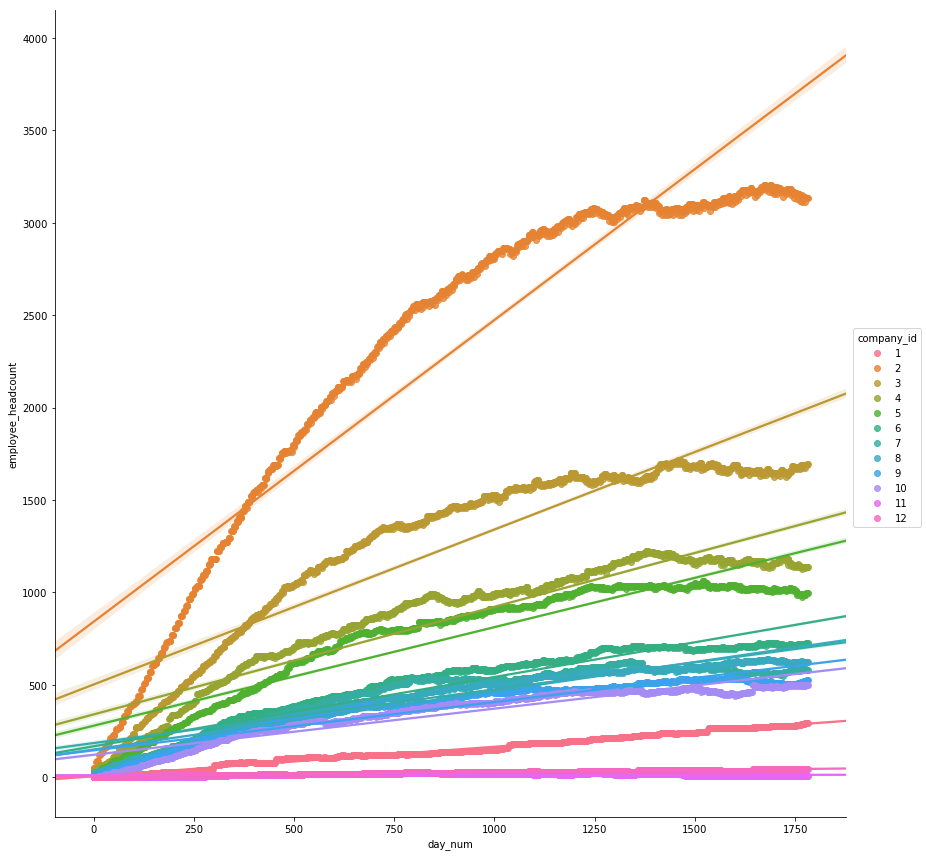

In [11]:
sn.lmplot(x='day_num', y='employee_headcount', data=hcount_df, hue='company_id', size=12)
plt.show()

In [12]:
quit_df, stayed_df = split_quit()

In [13]:
depts = df['dept'].unique()
comp_ids = df['company_id'].unique()

In [14]:
ds_cid = get_dept(get_comp(df, 2),'data_science')


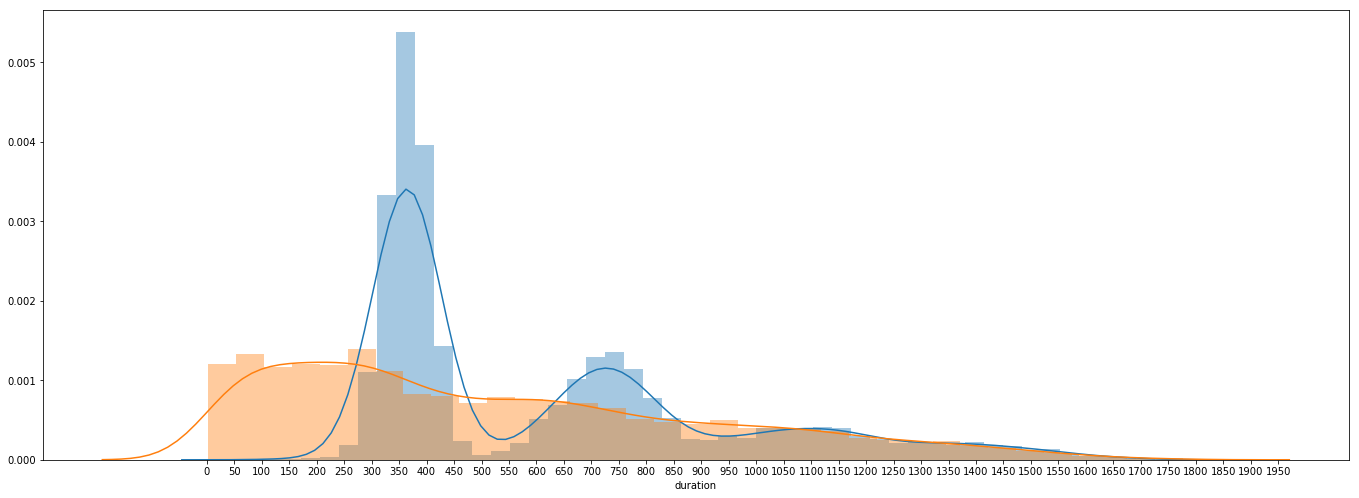

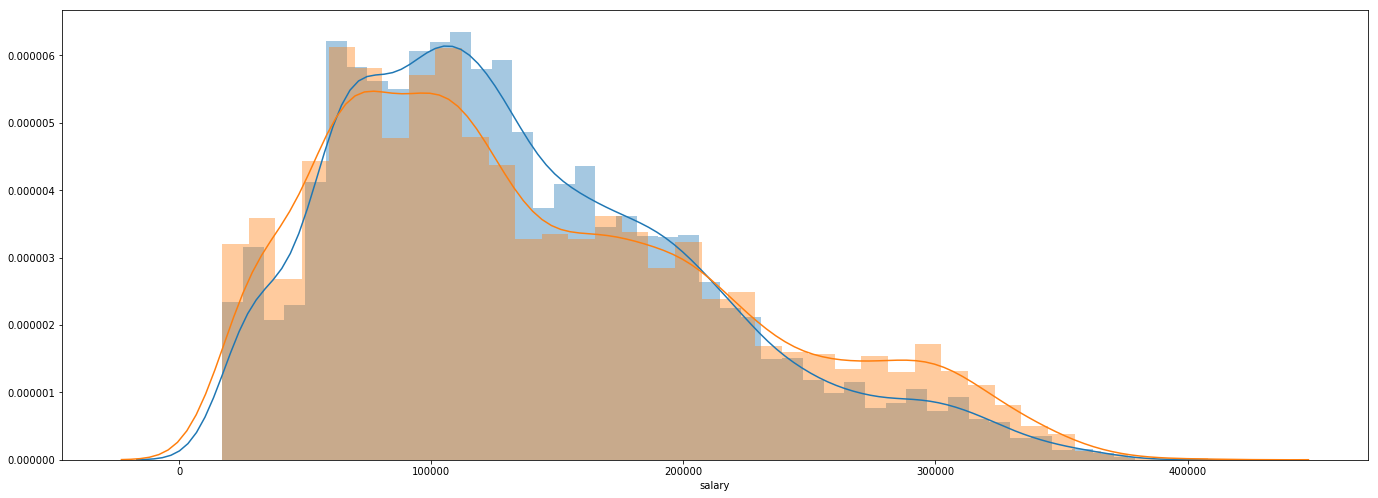

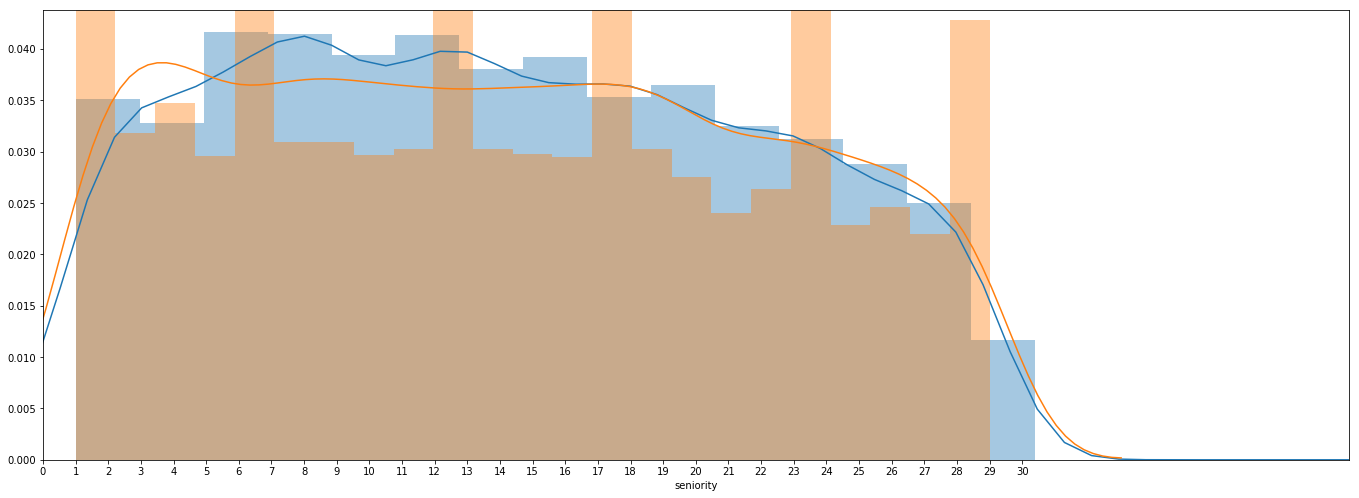

In [15]:
a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['duration'])
ax = sn.distplot(a=stayed_df['duration'])
ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['salary'])
ax = sn.distplot(a=stayed_df['salary'])
# ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['seniority'])
ax = sn.distplot(a=stayed_df['seniority'])
ax.set_xticks(np.arange(0,31,1))
ax.set_autoscaley_on(False)
ax.set_xlim([0,40])
plt.show()


In [16]:
def split_quit_trimodal():
    early_break = 500
    late_break = 900
    quit_df, stayed_df = split_quit()
    quit_early_df = quit_df.where(quit_df['duration'] <= early_break).dropna(how='all')
    quit_middle_df = quit_df.where((quit_df['duration'] > early_break) & (quit_df['duration'] <= late_break)).dropna(how='all')
    quit_late_df = quit_df.where(quit_df['duration'] > late_break).dropna(how='all')
    return quit_early_df, quit_middle_df, quit_late_df
quit_early_df, quit_middle_df, quit_late_df = split_quit_trimodal()

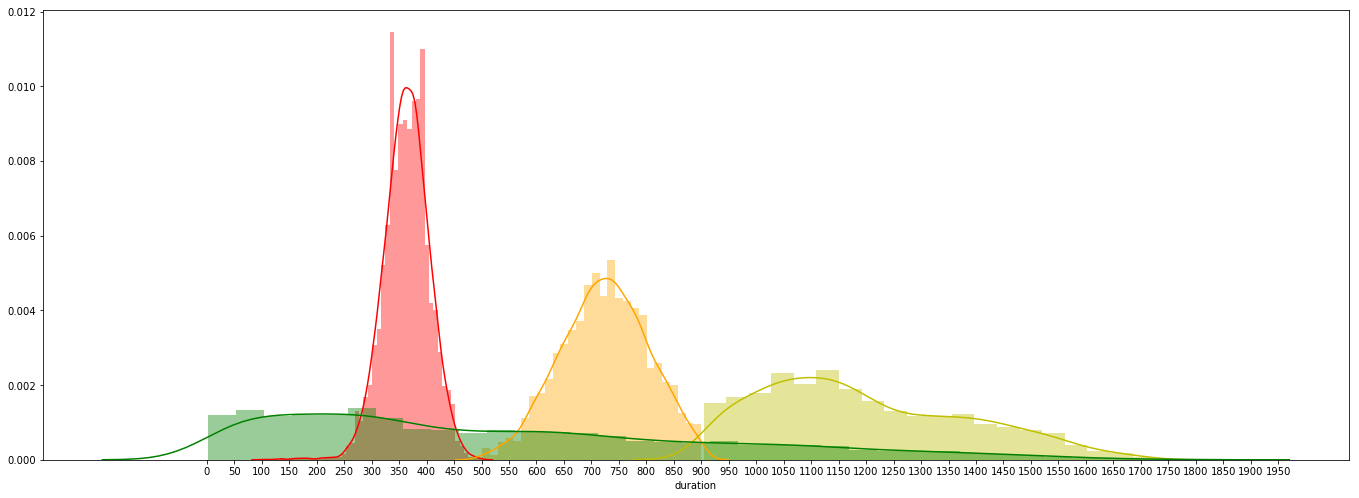

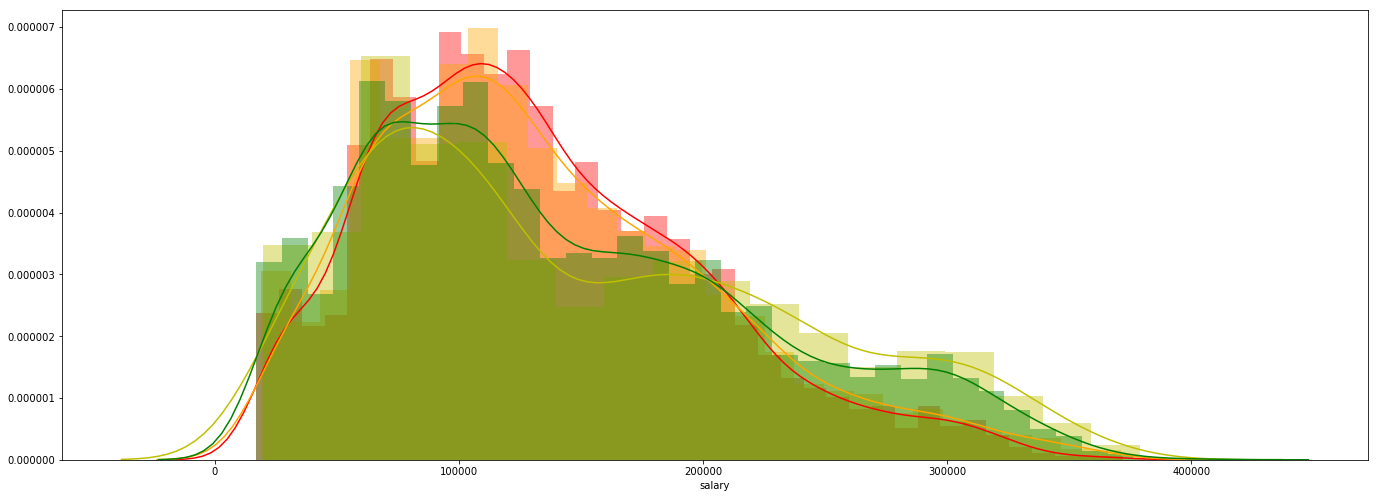

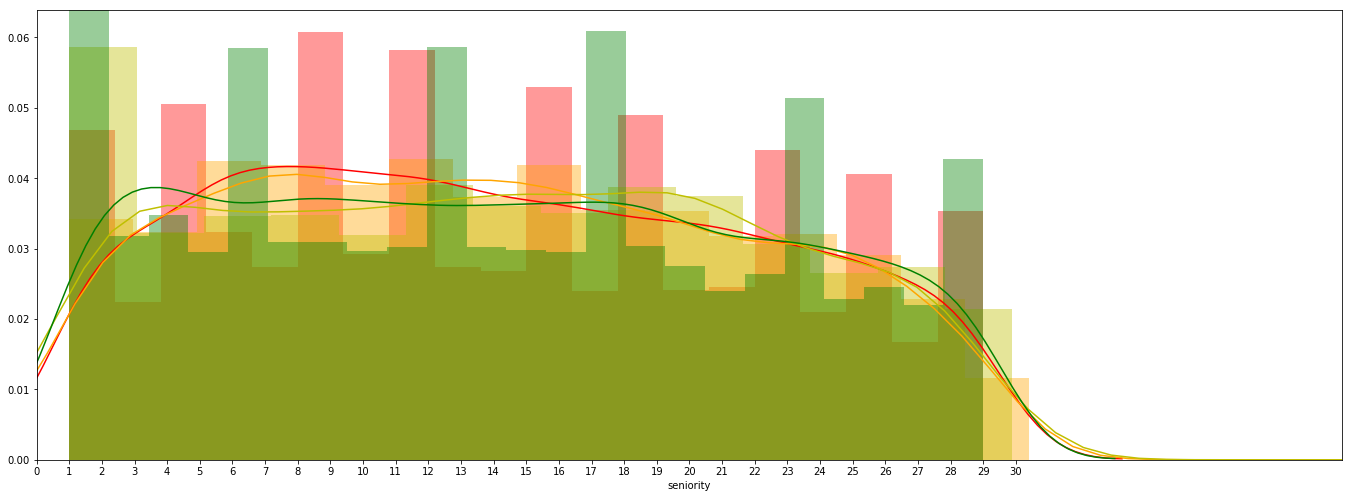

In [17]:
a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['duration'], color='red')
ax = sn.distplot(a=quit_middle_df['duration'], color='orange')
ax = sn.distplot(a=quit_late_df['duration'], color='y')
ax = sn.distplot(a=stayed_df['duration'], color='green')
ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['salary'], color='red')
ax = sn.distplot(a=quit_middle_df['salary'], color='orange')
ax = sn.distplot(a=quit_late_df['salary'], color='y')
ax = sn.distplot(a=stayed_df['salary'], color='green')
# ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['seniority'], color='red')
ax = sn.distplot(a=quit_middle_df['seniority'], color='orange')
ax = sn.distplot(a=quit_late_df['seniority'], color='y')
ax = sn.distplot(a=stayed_df['seniority'], color='green')
ax.set_xticks(np.arange(0,31,1))
ax.set_autoscaley_on(False)
ax.set_xlim([0,40])
plt.show()


In [18]:
def split_stayed_4modal():
    pre_early_break = 200
    early_break = 500
    late_break = 900
    quit_df, stayed_df = split_quit()
    stayed_new_df = quit_df.where(stayed_df['duration'] <= pre_early_break).dropna(how='all')
    stayed_during_1st_quit_df = stayed_df.where((stayed_df['duration'] < pre_early_break) & (stayed_df['duration'] >= early_break)).dropna(how='all')
    stayed_post_1st_quit_df = stayed_df.where((stayed_df['duration'] > early_break) & (stayed_df['duration'] <= late_break)).dropna(how='all')
    stayed_post_2nd_quit_df = stayed_df.where(stayed_df['duration'] > late_break).dropna(how='all')
    return stayed_new_df, stayed_during_1st_quit_df, stayed_post_1st_quit_df, stayed_post_2nd_quit_df


stayed_new_df, stayed_during_1st_quit_df, stayed_post_1st_quit_df, stayed_post_2nd_quit_df = split_stayed_4modal()

In [19]:
stayed_post_1st_quit_df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,time_since_join,time_until_quit,last_employment_day,duration,quit,salary/seniority,salary/duration,salary/(duration*seniority),seniority_at_end
12350,270.0,3.0,engineer,15.0,237000.0,2014-03-10,NaT,643 days,NaN,2015-12-13,643.0,0.0,15800.000000,368.584759,24.572317,16.0
8383,471.0,2.0,marketing,16.0,173000.0,2013-09-30,NaT,804 days,NaN,2015-12-13,804.0,0.0,10812.500000,215.174129,13.448383,18.0
18928,661.0,7.0,customer_service,21.0,81000.0,2014-05-05,NaT,587 days,NaN,2015-12-13,587.0,0.0,3857.142857,137.989779,6.570942,22.0
18658,1089.0,3.0,engineer,26.0,284000.0,2013-07-31,NaT,865 days,NaN,2015-12-13,865.0,0.0,10923.076923,328.323699,12.627835,28.0
7644,1650.0,5.0,engineer,3.0,61000.0,2014-02-03,NaT,678 days,NaN,2015-12-13,678.0,0.0,20333.333333,89.970501,29.990167,4.0
16361,1662.0,6.0,data_science,18.0,278000.0,2014-06-02,NaT,559 days,NaN,2015-12-13,559.0,0.0,15444.444444,497.316637,27.628702,19.0
15180,1980.0,5.0,engineer,24.0,233000.0,2014-07-21,NaT,510 days,NaN,2015-12-13,510.0,0.0,9708.333333,456.862745,19.035948,25.0
18099,2060.0,2.0,marketing,27.0,173000.0,2013-09-03,NaT,831 days,NaN,2015-12-13,831.0,0.0,6407.407407,208.182912,7.710478,29.0
8852,2293.0,1.0,marketing,4.0,55000.0,2013-08-05,NaT,860 days,NaN,2015-12-13,860.0,0.0,13750.000000,63.953488,15.988372,6.0
9927,2410.0,2.0,engineer,23.0,314000.0,2013-12-23,NaT,720 days,NaN,2015-12-13,720.0,0.0,13652.173913,436.111111,18.961353,24.0


In [20]:
quit_early_df['group'] = 'QuitEarly'
quit_middle_df['group'] = 'QuitMiddle'
quit_late_df['group'] = 'QuitLate'
# stayed_df['group'] = 'StillWorking'
stayed_new_df['group'] = 'StillWorkingNew'
stayed_during_1st_quit_df['group'] = 'StillWorkingDuring1stQuit'
stayed_post_1st_quit_df['group'] = 'StillWorkingPost1stQuit'
stayed_post_2nd_quit_df['group'] = 'StillWorkingPost2ndQuit'
labeled_df = pd.concat([quit_early_df, 
                        quit_middle_df, 
                        quit_late_df,
                        stayed_new_df,
                        stayed_during_1st_quit_df,
                        stayed_post_1st_quit_df,
                        stayed_post_2nd_quit_df
                       ])

In [21]:
labeled_df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,time_since_join,time_until_quit,last_employment_day,duration,quit,salary/seniority,salary/duration,salary/(duration*seniority),seniority_at_end,group
16636,70.0,2.0,engineer,6.0,220000.0,2013-01-07,2013-11-29,1070 days,326.0,2013-11-29,326.0,1.0,36666.666667,674.846626,112.474438,6.0,QuitEarly
3703,506.0,1.0,engineer,11.0,218000.0,2014-04-21,2015-05-08,601 days,382.0,2015-05-08,382.0,1.0,19818.181818,570.680628,51.880057,12.0,QuitEarly
10900,1374.0,1.0,sales,7.0,115000.0,2014-07-02,2015-08-21,529 days,415.0,2015-08-21,415.0,1.0,16428.571429,277.108434,39.586919,8.0,QuitEarly
15947,1393.0,1.0,sales,16.0,209000.0,2014-12-15,2015-10-16,363 days,305.0,2015-10-16,305.0,1.0,13062.500000,685.245902,42.827869,16.0,QuitEarly
21522,1849.0,8.0,engineer,22.0,272000.0,2013-05-28,2014-04-21,929 days,328.0,2014-04-21,328.0,1.0,12363.636364,829.268293,37.694013,22.0,QuitEarly
10186,1946.0,3.0,engineer,13.0,162000.0,2011-09-08,2012-10-05,1557 days,393.0,2012-10-05,393.0,1.0,12461.538462,412.213740,31.708749,14.0,QuitEarly
23713,2130.0,1.0,customer_service,4.0,24000.0,2012-02-21,2013-04-12,1391 days,416.0,2013-04-12,416.0,1.0,6000.000000,57.692308,14.423077,5.0,QuitEarly
24474,2233.0,4.0,customer_service,6.0,71000.0,2013-11-06,2014-11-07,767 days,366.0,2014-11-07,366.0,1.0,11833.333333,193.989071,32.331512,7.0,QuitEarly
10637,2267.0,1.0,data_science,6.0,208000.0,2011-10-17,2012-11-30,1518 days,410.0,2012-11-30,410.0,1.0,34666.666667,507.317073,84.552846,7.0,QuitEarly
9685,2537.0,1.0,customer_service,24.0,119000.0,2011-09-19,2012-08-31,1546 days,347.0,2012-08-31,347.0,1.0,4958.333333,342.939481,14.289145,24.0,QuitEarly


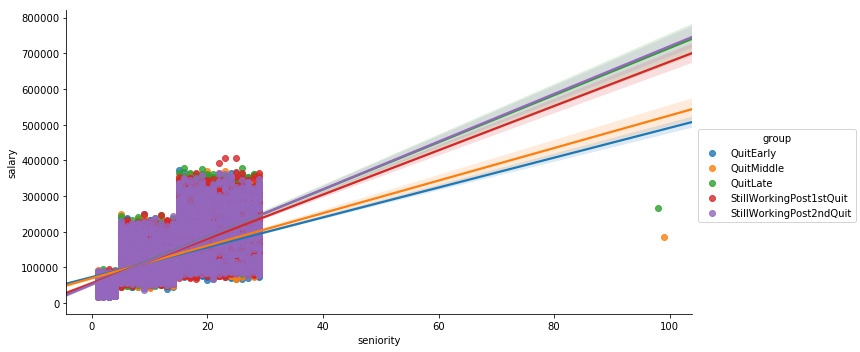

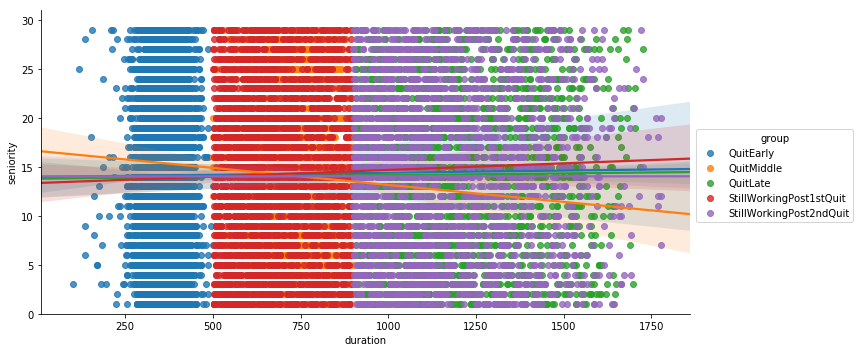

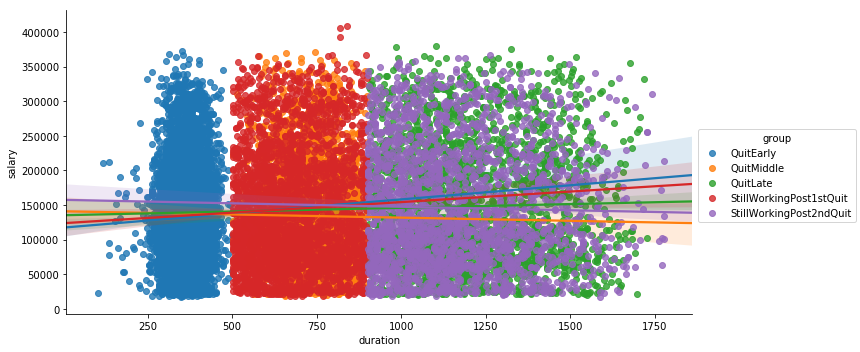

In [22]:
# fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.lmplot(x='seniority', y='salary', data=labeled_df, hue='group', aspect=2)
plt.show()
ax = sn.lmplot(x='duration', y='seniority', data=labeled_df, hue='group', aspect=2)
ax.axes[0,0].set_ylim([0,31])
plt.show()
ax = sn.lmplot(x='duration', y='salary', data=labeled_df, hue='group', aspect=2)
plt.show()

In [23]:
ax = sn.distplot(a=ds_cid['duration'])

In [24]:
std_scale = StandardScaler()
minmax_scale = MinMaxScaler()
maxabs_scale = MaxAbsScaler()

In [25]:
ids = labeled_df[['employee_id', 'company_id', 'dept']].copy()
X = labeled_df[[
    'salary', 
    'seniority', 
    'duration',
    'salary/seniority',
    'salary/duration',
    'salary/(duration*seniority)'
]].copy()
Y = pd.DataFrame(labeled_df[['quit', 'group']]).copy()
x_train, x_test, y_train, y_test, ids_train, ids_test = train_test_split(X,Y,ids, train_size=0.80, test_size=0.20,stratify=Y['group'])

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

# mnb = MultinomialNB()
# qda = QuadraticDiscriminantAnalysis()
# knc = KNeighborsClassifier(n_neighbors=50, weights='distance')
clf = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()
# clf = VotingClassifier(estimators=[
#     ('qda', qda),
#     ('knc', knc),
#     ('mnb', mnb),
#     ('abc_dtc', abc_dtc)
# ],voting='soft')
# clf2 = VotingClassifier(estimators=[
#     ('qda', qda),
#     ('knc', knc),
#     ('mnb', mnb),
#     ('abc_dtc', abc_dtc)
# ],voting='soft')

In [27]:
clf.fit(x_train, y_train['group'])
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)
print(classification_report(y_train['group'],train_pred))
print(classification_report(y_test['group'],test_pred))
print(X.columns)
print(clf.feature_importances_)

                         precision    recall  f1-score   support

              QuitEarly       1.00      1.00      1.00      5874
               QuitLate       1.00      1.00      1.00      1958
             QuitMiddle       1.00      1.00      1.00      2976
StillWorkingPost1stQuit       1.00      1.00      1.00      2298
StillWorkingPost2ndQuit       1.00      1.00      1.00      1729

            avg / total       1.00      1.00      1.00     14835

                         precision    recall  f1-score   support

              QuitEarly       1.00      1.00      1.00      1468
               QuitLate       0.75      0.76      0.75       490
             QuitMiddle       0.90      0.90      0.90       744
StillWorkingPost1stQuit       0.87      0.87      0.87       575
StillWorkingPost2ndQuit       0.72      0.72      0.72       432

            avg / total       0.89      0.89      0.89      3709

Index(['salary', 'seniority', 'duration', 'salary/seniority',
       'salary/duratio

In [28]:
clf2.fit(x_train, y_train['quit'])
train_pred = clf2.predict(x_train)
test_pred = clf2.predict(x_test)
print(classification_report(y_train['quit'], train_pred))
print(classification_report(y_test['quit'], test_pred))
print(X.columns)
print(clf2.feature_importances_)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4027
        1.0       1.00      1.00      1.00     10808

avg / total       1.00      1.00      1.00     14835

             precision    recall  f1-score   support

        0.0       0.79      0.80      0.79      1007
        1.0       0.92      0.92      0.92      2702

avg / total       0.89      0.89      0.89      3709

Index(['salary', 'seniority', 'duration', 'salary/seniority',
       'salary/duration', 'salary/(duration*seniority)'],
      dtype='object')
[ 0.04859112  0.02498537  0.77589259  0.04099736  0.05509619  0.05443736]


In [29]:
# x_train
X_pred = clf2.predict(X)
labeled_quit_df = labeled_df.where(labeled_df['quit'] == 1).dropna(how='all')

In [30]:
ids_quit = labeled_quit_df[['employee_id', 'company_id', 'dept']].copy()
X_quit = labeled_quit_df[[
    'salary', 
    'seniority', 
#     'duration',
    'salary/seniority',
#     'salary/duration',
#     'salary/(duration*seniority)'
]].copy()
Y_quit = pd.DataFrame(labeled_quit_df[['quit', 'group']]).copy()
x_quit_train, x_quit_test, y_quit_train, y_quit_test, ids_quit_train, ids_quit_test = train_test_split(X_quit,Y_quit,ids_quit, train_size=0.80, test_size=0.20,stratify=Y_quit['group'])

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf3 = QuadraticDiscriminantAnalysis()
clf3 = DecisionTreeClassifier()

In [32]:
clf3.fit(x_quit_train, y_quit_train['group'])
train_pred = clf3.predict(x_quit_train)
test_pred = clf3.predict(x_quit_test)
print(classification_report(y_quit_train['group'], train_pred))
print(classification_report(y_quit_test['group'], test_pred))

             precision    recall  f1-score   support

  QuitEarly       0.70      0.93      0.80      5874
   QuitLate       0.71      0.46      0.56      1958
 QuitMiddle       0.77      0.44      0.56      2976

avg / total       0.72      0.71      0.69     10808

             precision    recall  f1-score   support

  QuitEarly       0.55      0.71      0.62      1468
   QuitLate       0.20      0.14      0.17       490
 QuitMiddle       0.29      0.18      0.22       744

avg / total       0.42      0.46      0.43      2702



In [33]:
X_was_quit = pd.Series(X_pred == 1.0)
# print(labeled_df)
X_quit = X.where(X_was_quit).dropna(how='all')
# print(X_quit.shape)
Y_quit = Y.where(X_was_quit).dropna(how='all')
# print(Y_quit.shape)
ids_quit = ids.where(X_was_quit).dropna(how='all')
# print(ids_quit.shape)

In [34]:
X_quit_pred = clf3.predict(X_quit[['salary','seniority','salary/seniority']])
print(classification_report(Y_quit['group'], X_quit_pred))

                         precision    recall  f1-score   support

              QuitEarly       0.49      0.89      0.64      4003
               QuitLate       0.42      0.41      0.42      1354
             QuitMiddle       0.48      0.38      0.43      2012
StillWorkingPost1stQuit       0.00      0.00      0.00      1548
StillWorkingPost2ndQuit       0.00      0.00      0.00      1199

            avg / total       0.35      0.48      0.39     10116



/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
print(['salary','seniority','salary/seniority'])
print(clf3.feature_importances_)

['salary', 'seniority', 'salary/seniority']
[ 0.39240653  0.09721231  0.51038117]


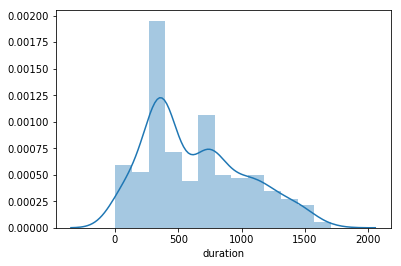

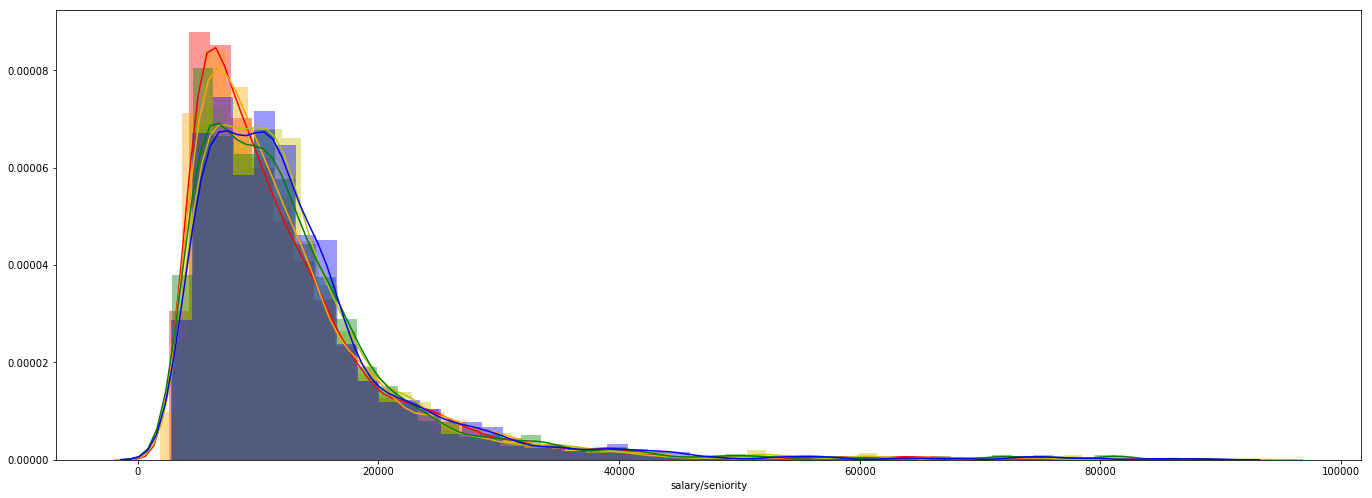

In [36]:
plotstr = 'salary/seniority'
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df[plotstr], color='red')
ax = sn.distplot(a=quit_middle_df[plotstr], color='orange')
ax = sn.distplot(a=quit_late_df[plotstr], color='y')
ax = sn.distplot(a=stayed_post_1st_quit_df[plotstr], color='green')
ax = sn.distplot(a=stayed_post_2nd_quit_df[plotstr], color='blue')
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,1000])
# ax.set_ylim([0, 0.007])
plt.show()

In [37]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures()
xdf = X[['salary', 'seniority', 'duration']]
xdf.shape

(18544, 3)

In [39]:
polydf =  pf.fit_transform(xdf)
x_poly_train, x_poly_test, y_poly_train, y_poly_test, ids_poly_train, ids_poly_test = train_test_split(xdf,Y,ids, train_size=0.80, test_size=0.20,stratify=Y['group'])

In [40]:
sgd = SGDClassifier(loss='log', alpha=1e12, tol=1e-6, max_iter=9000, penalty='elasticnet')

In [41]:
sgd.fit(x_poly_train, y_poly_train['group'])

SGDClassifier(alpha=1000000000000.0, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=9000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-06, verbose=0, warm_start=False)

In [42]:
x_poly_train_pred = sgd.predict(x_poly_train)
x_poly_test_pred = sgd.predict(x_poly_test)
print(classification_report(y_poly_train['group'], x_poly_train_pred))
print(classification_report(y_poly_test['group'], x_poly_test_pred))

                         precision    recall  f1-score   support

              QuitEarly       0.40      1.00      0.57      5874
               QuitLate       0.00      0.00      0.00      1958
             QuitMiddle       0.00      0.00      0.00      2976
StillWorkingPost1stQuit       0.00      0.00      0.00      2298
StillWorkingPost2ndQuit       0.00      0.00      0.00      1729

            avg / total       0.16      0.40      0.22     14835

                         precision    recall  f1-score   support

              QuitEarly       0.40      1.00      0.57      1468
               QuitLate       0.00      0.00      0.00       490
             QuitMiddle       0.00      0.00      0.00       744
StillWorkingPost1stQuit       0.00      0.00      0.00       575
StillWorkingPost2ndQuit       0.00      0.00      0.00       432

            avg / total       0.16      0.40      0.22      3709



/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
from sklearn.preprocessing import PolynomialFeatures
stdscaler = StandardScaler()
pf = PolynomialFeatures()
x_dur_df = stdscaler.fit_transform(pf.fit_transform(X[['salary', 'seniority']]))
y_dur_df = X['duration']
x_dur_train, x_dur_test, y_dur_train, y_dur_test = train_test_split(x_dur_df, y_dur_df, train_size=0.80, test_size=0.20, stratify=Y['group'])

In [44]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [45]:
reg = RadiusNeighborsRegressor(radius=1.0, weights='distance', p=3)


In [46]:
reg.fit(x_dur_train, y_dur_train)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, p=3, radius=1.0, weights='distance')

In [47]:
x_dur_train_predict = reg.predict(x_dur_train)
x_dur_test_predict = reg.predict(x_dur_test)
# explained_variance_score(y_dur_train, x_dur_train_predict)

In [ ]:
# pd.Series(x_dur_train_predict)

In [ ]:
# y_dur_train